<a href="https://colab.research.google.com/github/bhuvnk/EVA/blob/master/Session10/Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and modules**

In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import keras.backend as K

from keras.utils import np_utils
from keras.datasets import mnist

# GRADCAM

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [0]:
model = VGG16(weights="imagenet")


In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
from skimage import io
from google.colab.patches import cv2_imshow

def whatchyalookingat(img_loc, layer_n, class_idx=None, original=False):
  img = io.imread(img_loc)
  img = cv2.resize(img, dsize=(224, 224))

  x = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  preds = model.predict(x)
  if class_idx==None:
    class_idx = np.argmax(preds[0])
#   print(class_idx)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_n)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
#   print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
#   print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(last_conv_layer.output_shape[3]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  heatmap = np.mean(conv_layer_output_value, axis = -1)
#   print(conv_layer_output_value.shape)
#   print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
#   return(superimposed_img)
  if original:
    cv2_imshow(img)
  cv2_imshow(superimposed_img)

## Getting the output for last 3 layers

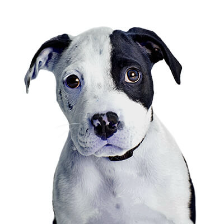

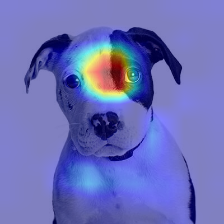

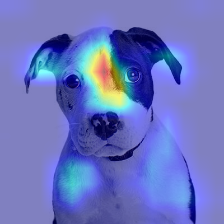

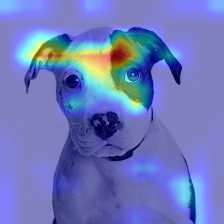

In [93]:
whatchyalookingat("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg", "block5_conv3", original=True)
whatchyalookingat("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg", "block5_conv2")
whatchyalookingat("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg", "block5_conv1")

# Finding ToneyStark's Glasses

In [86]:
!wget https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
tony = '/content/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg'

--2019-07-02 00:49:18--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.244.83, 141.101.114.84, 190.93.245.83, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.244.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58670 (57K) [image/jpeg]
Saving to: ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.6’

16_scale_tony_stark 100%[===================>]  57.29K  --.-KB/s    in 0.007s  

2019-07-02 00:49:18 (7.59 MB/s) - ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.6’ saved [58670/58670]



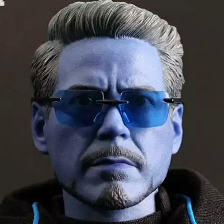

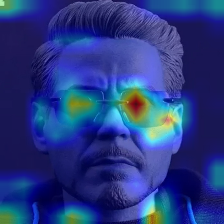

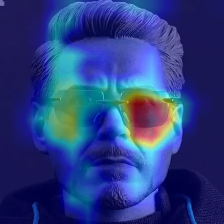

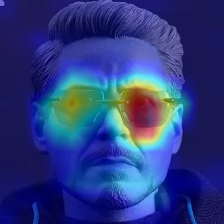

In [87]:
whatchyalookingat(tony, "block5_conv1", class_idx=837, original=True)
whatchyalookingat(tony, "block5_conv2", class_idx=837)
whatchyalookingat(tony, "block5_conv3", class_idx=837)